In [1]:
import rasterio
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime

In [2]:
def calc_ndvi(image_file):
    with rasterio.open(image_file) as src:
        band_red = src.read(3)

    with rasterio.open(image_file) as src:
        band_nir = src.read(4)
        np.seterr(divide='ignore', invalid='ignore')

    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)
    return ndvi

## NDVI for one example

In [4]:
root_dir = 'data'
image_file = '20200814_105841_1053_3B_AnalyticMS.tif'

path = Path(root_dir).rglob(image_file)
ndvi = calc_ndvi(next(path))
print(f'{np.nanmin(ndvi)}, {np.nanmax(ndvi)}')

-0.7932651321398124, 0.7209793161671592


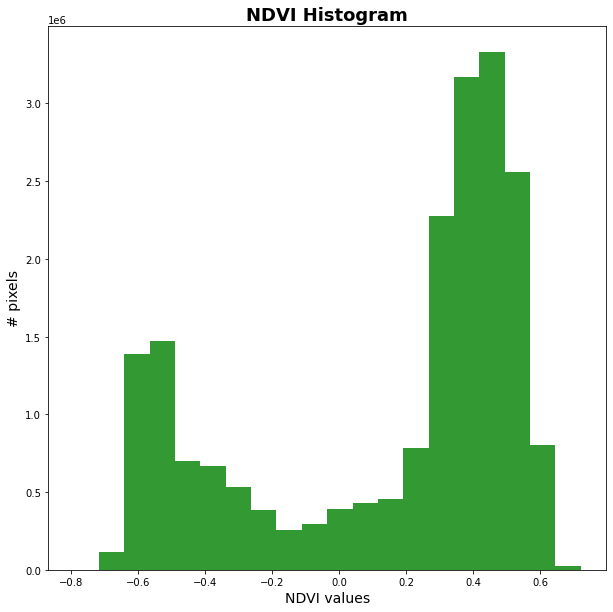

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)
plt.show()

## Aggregate NDVI from all examples

In [6]:
results = []
root_dir = 'data'
for path in Path(root_dir).rglob('*MS.tif'):
    print(f'processing: {path.name}')
    ndvi = calc_ndvi(path)
    dt = datetime.datetime.strptime(path.name[0:15], '%Y%m%d_%H%M%S')
    results.append((dt, np.nanmean(ndvi), np.nanmin(ndvi), np.nanmax(ndvi)))
#[print(r) for r in results];

processing: 20200814_105841_1053_3B_AnalyticMS.tif
processing: 20200814_105836_1053_3B_AnalyticMS.tif
processing: 20200814_105837_1053_3B_AnalyticMS.tif
processing: 20200814_105840_1053_3B_AnalyticMS.tif
processing: 20200814_105838_1053_3B_AnalyticMS.tif
processing: 20200814_105839_1053_3B_AnalyticMS.tif


## Write dataframe

Write results to a dataframe using acquired datatime as index

In [7]:
df = pd.DataFrame(results, columns=['acquired', 'mean', 'min', 'max'])
df = df.set_index('acquired')
df.head()

,mean,min,max
acquired,,,
2020-08-14 10:58:41,0.149489,-0.793265,0.720979
2020-08-14 10:58:36,-0.118987,-0.915309,0.732886
2020-08-14 10:58:37,-0.100198,-0.903243,0.714040
2020-08-14 10:58:40,0.123089,-0.863510,0.721687
2020-08-14 10:58:38,-0.038980,-0.913344,0.720332


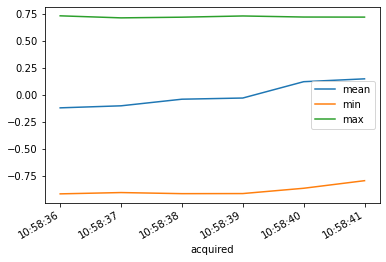

In [8]:
fig, ax = plt.subplots()
df.plot(ax=ax)
plt.show()

In [9]:
df.to_csv('first_results.csv')

In [10]:
results_df = pd.read_csv('first_results.csv', index_col='acquired', parse_dates=True)
results_df.head()

,mean,min,max
acquired,,,
2020-08-14 10:58:41,0.149489,-0.793265,0.720979
2020-08-14 10:58:36,-0.118987,-0.915309,0.732886
2020-08-14 10:58:37,-0.100198,-0.903243,0.714040
2020-08-14 10:58:40,0.123089,-0.863510,0.721687
2020-08-14 10:58:38,-0.038980,-0.913344,0.720332
